In [1]:
import numpy as np
import pandas as pd
import random

import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from IPython import display
%matplotlib inline

from itertools import chain
from scipy.stats import norm, laplace
from scipy.stats import gaussian_kde
from scipy.stats import linregress
from scipy.optimize import minimize

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, brier_score_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from scipy.stats import t
from statsmodels.stats.multitest import multipletests

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

# Code for experiments

In [2]:
def experiment_synthetic(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, distribution='laplace', 
                         n_networks=10, n_rep=10, find_alpha=True, random_state=0):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    hid_dim = 32
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
    
    np.random.seed(random_state)
    n_seeds = len(alphas) * len(params) * n_rep
    seeds = np.arange(n_seeds)
    np.random.shuffle(seeds)
    np.random.seed(None)
    
    fixed_alpha = None
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                random_state, seeds = seeds[-1], seeds[:-1] # pop analogue
                
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=random_state, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                target_mix = target_mix[target_mix != 2]

                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                cons_poster =  estimate_cons_poster(data[target_pu == 1].reshape(-1,), 
                                                    mu, s, distribution, alpha, cons_alpha)

                if not find_alpha:
                    fixed_alpha = cons_alpha
                res = dict()
                res = estimate_poster_cv(data, target_pu, estimator='ntc_methods', alpha=fixed_alpha,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={
                                             'MT': True, 'MT_coef': 0.25, 'decay_MT_coef': False,
                                             'bw_mix': 0.05, 'bw_pos': 0.1, 'threshold': 'high', 'k_neighbours': 150,
                                         },
                                         estimate_preds_cv_options={
                                             'NN1': {
                                                 'fun': estimate_preds_cv,
                                                 'n_networks': n_networks,
                                                 'cv': 3,
                                                 'random_state': random_state,
                                                 'hid_dim': 32,
                                                 'n_hid_layers': 3,
                                                 'lr': 5 * 10**-4,
                                                 'prevent_overfit': False,
                                                 'train_nn_options': 
                                                 {
                                                     'n_epochs': 200, 'batch_size': 64, 'loss_function': 'log',
                                                     'n_batches': 30, 'n_early_stop': 3, 'disp': False,                                                 
                                                 }
                                             },
#                                              'NN2': {
#                                                  'fun': estimate_preds_cv,
#                                                  'n_networks': n_networks,
#                                                  'cv': 3,
#                                                  'random_state': random_state,
#                                                  'hid_dim': 8,
#                                                  'n_hid_layers': 1,
#                                                  'lr': 5 * 10**-3,
#                                                  'prevent_overfit': False,
#                                                  'train_nn_options': 
#                                                  {
#                                                      'n_epochs': 200, 'batch_size': 64, 'loss_function': 'log',
#                                                      'n_batches': 30, 'n_early_stop': 2, 'disp': False,
#                                                  }                                                 
#                                              },
#                                              'catboost': {
#                                                  'fun': estimate_preds_cv_catboost,
#                                                  'n_early_stop': 20,
#                                                  'n_networks': n_networks,
#                                                  'cv': 3,
#                                                  'random_state': random_state,
#                                                  'catboost_params': {'iterations': 500, 'depth': 3, 
#                                                                      'learning_rate': 0.1, 'l2_leaf_reg': 3}
#                                              },
#                                              'svm': {
#                                                  'fun': estimate_preds_cv_sklearn,
#                                                  'n_networks': n_networks,
#                                                  'cv': 3,
#                                                  'random_state': random_state,
#                                                  'model': SVC,
#                                                  'params': {'kernel': kernel, 'degree': 2, 'probability': True, 
#                                                             'C': 0.1, 'max_iter': 100000}
#                                              },
                                         }
                                        )
                
#                 res['nnre'] = estimate_poster_cv(data, target_pu, estimator='nnre', alpha=cons_alpha,
#                                                  estimate_preds_cv_options={
#                                                      'NN1': {
#                                                          'fun': estimate_preds_cv,
#                                                          'alpha': cons_alpha,
#                                                          'n_networks': n_networks,
#                                                          'cv': 3,
#                                                          'random_state': random_state,
#                                                          'hid_dim': 32,
#                                                          'n_hid_layers': 3,
#                                                          'lr': 5 * 10**-4,
#                                                          'prevent_overfit': False,
#                                                          'training_mode': 'nnre',
#                                                          'train_nn_options': 
#                                                          {
#                                                              'n_epochs': 30, 'batch_size': 64, 'loss_function': 'brier',
#                                                              'n_batches': 30, 'n_early_stop': 10, 'disp': False,                                                 
#                                                          }
#                                                      },
#                                                  },
#                                                 )

                for key in res.keys():
                    est_alpha, poster = res[key]
                    
                    cur_result = [distribution, key, i, mu, s, alpha, cons_alpha, est_alpha]
                    cur_result.append(np.mean(poster))
                    cur_result.append(accuracy_score(target_mix, poster.round()))
                    cur_result.append(roc_auc_score(target_mix, poster))
                    cur_result.append(mean_absolute_error(cons_poster, poster))
                    cur_result.append(np.sqrt(mean_squared_error(cons_poster, poster)))
                    cur_result.append(log_loss(target_mix, poster))
                    cur_result.append(precision_score(target_mix, poster.round()))
                    cur_result.append(recall_score(target_mix, poster.round()))
                    cur_result.append(balanced_accuracy_score(target_mix, poster.round()))
                    cur_result.append(brier_score_loss(target_mix, poster))
                    results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'estimator', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'est_alpha', 'mean_poster',
                                                'accuracy', 'roc', 'mae', 'rmse', 'log_loss', 'precision', 'recall',
                                                'accuracy_balanced', 'brier_score',])
    return df_results

In [3]:
res = experiment_synthetic(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                   n_networks=10, n_rep=10, distribution='laplace', 
#                                   find_alpha=True)
                                   find_alpha=False)

res = res.round(5)
res.to_csv('experiment_synthetic_poster.csv', index=False, sep=';', decimal=',')

In [ ]:
res['alpha_mae'] = (res['cons_alpha'] - res['est_alpha']).abs()
res_grouped = res.groupby(['distribution', 'ds', 'dmu', 'alpha', 'cons_alpha', 'estimator']).mean().drop(
    ['est_alpha', 'random_state'], axis=1).reset_index()

In [ ]:
res_pivot_alpha = res_grouped.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha'],# 'cons_alpha'],
                        columns=['estimator'],
                        values='alpha_mae')

In [ ]:
res_pivot_mae = res_grouped.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha'], #, 'cons_alpha'
                        columns=['estimator'],
                        values='mae')

## KM

implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

In [4]:
def experiment_synthetic_KM(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, distribution='normal', 
                            n_rep=10, **kwargs):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
        
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=i, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                
                try:
                    KM_2 = wrapper(data[target_pu == 1], data[target_pu == 0], disp=False, 
                                   KM_1=False, KM_2=True, lambda_lower_bound=0.5, lambda_upper_bound=10)
                    KM_2 = 1 - KM_2
                except ValueError as e:
                    print(e)
                    KM_2 = np.nan
                
                cur_result = [distribution, i, mu, s, alpha, cons_alpha, KM_2]
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'KM_2'])
    return df_results

In [2]:
res_KM = experiment_synthetic_KM(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                   n_rep=10, distribution='laplace')

res_KM = res_KM.round(4)
res_KM.to_csv('KMPE_synthetic.csv', index=False, sep=';', decimal=',')

In [25]:
res_KM['KM_2_mae'] = (res_KM['cons_alpha'] - res_KM['KM_2']).abs()
res_KM_pivot_alpha = res_KM.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha', 'cons_alpha', 'random_state'],
                        values=['KM_2_mae'])

res_pivot_alpha = res_KM_pivot_alpha.merge(res_pivot_alpha, left_index=True, right_index=True)

# Results of Experiments

In [9]:
res_pivot_alpha = pd.read_csv('experimental_data//alpha_synth.csv', sep=';', decimal=',')
res_pivot_mae = pd.read_csv('experimental_data//mae_synth.csv', sep=';', decimal=',')

In [10]:
params = ((1, 1), (2, 1), (4, 1), (0, 2), (0, 4))
def plot_results_synthetic(res_plt, distribution, ylims=None, reverse_alpha=False, save_name=None, dpi=200,
                           alpha_mode=True):
    
    if distribution == 'laplace':
        symbol = 'L'
    elif distribution == 'normal':
        symbol = 'N'
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
        
    if ylims is None:
        ylims = {}
    
    fig = plt.figure(0)
    gridspec.GridSpec(1,3)
    fig.set_size_inches(w=30, h=5.5)
#     fig.legend(handles=(Line2D([], [], linestyle='-', color='w', marker='.'),
#                         Line2D([], [], linestyle='--', color='r', marker='s'),
#                         Line2D([], [], linestyle='-.', color='k', marker='o')),
#                labels=('$f_p = {}(0, 1)$'.format(symbol), 'KM2', 'DEDPUL'),
#                bbox_to_anchor=(0.52, 0.88),
#                fontsize='xx-large')

    for i, (mu, s) in enumerate(params):
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu) &(res_plt['ds'] == s)]
        plt.subplot2grid((1,5), (0,i), colspan=1, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 23})

        if not alpha_mode:
            plt.plot(res_plt_cur['alpha'], res_plt_cur['brier_nnre'], 'gs-.')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['sigmoid_nnre'], c='b', marker='*', ls='--')
        else:
            plt.plot(res_plt_cur['alpha'], res_plt_cur['KM'], 'rs--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['e3_en'], c='orange', marker='x', ls=':')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-')
        
        plt.xticks((0.05, 0.25, 0.5, 0.75, 0.95), fontsize='xx-large')
        plt.xlim(0, 1)
        plt.yticks(fontsize='xx-large')
        if i in ylims.keys():
            plt.ylim(0, ylims[i])
            
        plt.xlabel(r'$\alpha$', fontsize='xx-large')
        if i == 0:
            if not alpha_mode:
                plt.ylabel(r'E$\left| f^*(p \mid x) - \widetilde{f}^*(p \mid x)\right|$', fontsize='xx-large')
            else:
                plt.ylabel(r'$\alpha^* - \widetilde{\alpha}^*$', fontsize='xx-large')
                
        if i == 2:
            if not alpha_mode:
                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], linestyle='-.', color='g', marker='s'),
                                    Line2D([], [], linestyle='--', color='b', marker='*'),
                                    Line2D([], [], linestyle='-', color='k', marker='o')),
                          labels=('EN', 'nnRE-brier', 'nnRE-sigmoid', 'DEDPUL'), loc='upper left', fontsize='xx-large')
            else:

                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], linestyle='--', color='r', marker='s'),
                                    Line2D([], [], linestyle='-', color='k', marker='o')),
                           labels=('EN', 'KM2', 'DEDPUL'),  loc='upper center', fontsize='xx-large')

    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)
               

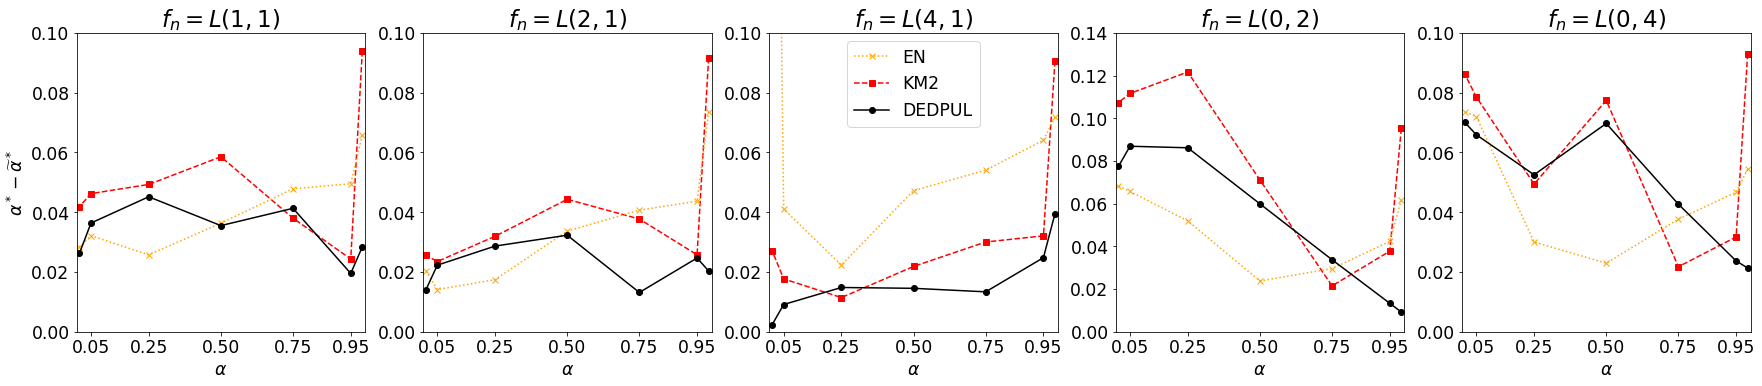

In [11]:
plot_results_synthetic(res_pivot_alpha.copy().reset_index(), 'laplace', reverse_alpha=True,
                       ylims={0: 0.1, 1: 0.1, 2: 0.1, 3: 0.14, 4: 0.1}, alpha_mode=True,
                      )#save_name='synth_alpha_nips')

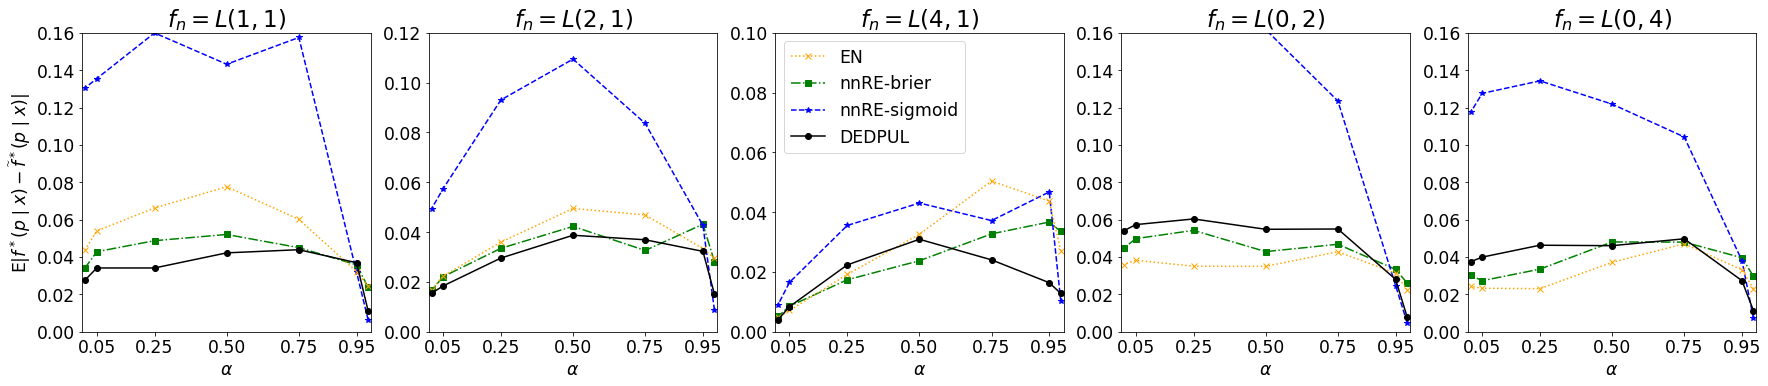

In [12]:
plot_results_synthetic(res_pivot_mae.copy().reset_index(), 'laplace', reverse_alpha=True,
                       ylims={0: 0.16, 1: 0.12, 2: 0.1, 3: 0.16, 4: 0.16}, alpha_mode=False,
                      )#save_name='synth_alpha_nips')